## Predicción de precio de BTC usando Modelos LSTM

En esta sección exploramos el uso de redes neuronales recurrentes (RNN), específicamente modelos **LSTM (Long Short-Term Memory)**, para predecir el precio de Bitcoin (BTC).

Los modelos LSTM son capaces de capturar **patrones no lineales complejos** y **dependencias a largo plazo** en series temporales. Esto los hace especialmente útiles cuando se trabaja con datos financieros que presentan alta volatilidad, ruido y relaciones no triviales entre variables.

El enfoque LSTM no requiere distinguir entre variables endógenas y exógenas de forma explícita, ya que toda la información relevante puede ser aprendida automáticamente por la red durante el entrenamiento. Sin embargo, la calidad de las predicciones depende fuertemente de la selección de variables de entrada, el preprocesamiento y la arquitectura de la red.

Utilizaremos arquitecturas LSTM supervisadas, entrenadas con ventanas temporales fijas que permiten a la red aprender patrones históricos en los datos para anticipar los retornos futuros de BTC.

### Configuración de Ventanas Temporales

Para la entrada del modelo LSTM, organizaremos los datos en **ventanas móviles de 30 días**. Esto significa que cada ejemplo de entrenamiento contendrá la información de los 30 días previos, y la red aprenderá a predecir el retorno del siguiente día. Este enfoque permite capturar dinámicas de corto y mediano plazo, que pueden ser relevantes para predecir movimientos en los mercados financieros.

In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from tabulate import tabulate

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Input
from tensorflow.keras.models import Sequential

### Modelo LSTM Simple

Una red LSTM básica con una sola capa LSTM seguida de una capa densa para predicción.

Capacidad moderada para capturar patrones temporales.

Útil como línea base para comparar modelos más complejos.

In [175]:
def base_lstm(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(50),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

### Modelo Bidireccional LSTM con Dropout

Incorpora una capa LSTM bidireccional para capturar dependencias pasadas y futuras, junto con capas de Dropout para evitar sobreajuste.

Mejor captura de contexto temporal.

Regularización mediante Dropout para mayor robustez.

In [176]:
def big_bidirectional_lstm(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Bidirectional(LSTM(128, return_sequences=True, activation='tanh')),
        Dropout(0.2),
        LSTM(64, activation='tanh'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

### Modelo LSTM Profundo

Una arquitectura con múltiples capas LSTM apiladas para modelar patrones temporales complejos.

Mayor capacidad para representar dinámicas no lineales complejas.

Puede requerir más datos y entrenamiento cuidadoso para evitar sobreajuste.

In [177]:
def cnn_lstm(input_shape):
    from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(64),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

### Modelo LSTM con Capa de Atención (Attention)

Combina LSTM con un mecanismo de atención que permite al modelo enfocarse en pasos temporales relevantes durante la predicción.

Mejora la interpretabilidad y el desempeño en secuencias largas.

Útil para capturar relaciones temporales no uniformes en el tiempo.

In [178]:
def stacked_lstm(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(64, return_sequences=True),
        LSTM(32),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [179]:
def load_and_scale(csv_path: str, features: list[str], seq_len: int = 30):
    if 'btc_close' not in features:
        features = ['btc_close'] + features

    df = (
        pd.read_csv(csv_path, index_col=0, parse_dates=True)[features]
        .dropna()
    )

    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df)

    split = int(len(scaled) * 0.8)

    train_data = scaled[:split]
    test_data  = scaled[split:]

    train_generator = TimeseriesGenerator(train_data, train_data[:, 0], length=SEQ_LEN, batch_size=16)
    test_generator  = TimeseriesGenerator(test_data,  test_data[:, 0], length=SEQ_LEN, batch_size=16)

    generators = {
        "train": train_generator,
        "test": test_generator,
    }
    return df.index, scaler, train_data, test_data, generators, split

In [180]:
def aic_bic(loss, n_params, n_obs):
    """Calcula AIC y BIC a partir del MSE (loss) del set de test."""
    rss = loss * n_obs        # RSS ≈ MSE * n
    loglike = -0.5 * n_obs * np.log(rss / n_obs)
    aic = 2 * n_params - 2 * loglike
    bic = np.log(n_obs) * n_params - 2 * loglike
    return aic, bic

In [181]:
def graph_convergence(history):
    # --- Graficar convergencia del entrenamiento ---
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Pérdida Entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('Loss (MSE)')
    plt.title('Convergencia del modelo')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [182]:
def evaluate(model, test_gen, test_data, scaler, split_idx, index, seq_len=30, return_preds=False):
    # ---------- predicciones ----------
    pred_scaled = model.predict(test_gen, verbose=0).ravel()

    y_test = test_data[seq_len:, 0]
    test_dates = index[split_idx + seq_len:]

    # ---------- des‑escalar ----------
    btc_scaler = MinMaxScaler()
    btc_scaler.min_, btc_scaler.scale_ = scaler.min_[0], scaler.scale_[0]

    y_true = btc_scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()
    y_pred = btc_scaler.inverse_transform(pred_scaled.reshape(-1, 1)).ravel()

    # ---------- métricas ----------
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    n_obs = len(y_true)
    k = model.count_params()
    mse = np.mean((y_true - y_pred) ** 2)
    ll  = -0.5 * n_obs * (np.log(2 * np.pi) + np.log(mse) + 1)
    aic = 2 * k - 2 * ll
    bic = k * np.log(n_obs) - 2 * ll

    if return_preds:
        return {'mae': mae, 'rmse': rmse, 'aic': aic, 'bic': bic}, y_true, y_pred, test_dates
    return {'mae': mae, 'rmse': rmse, 'aic': aic, 'bic': bic}

In [183]:
def graph_prediction(test_dates, y_true, y_pred, model_name, feat_name):
    plt.figure(figsize=(14, 6))
    plt.plot(test_dates, y_true, label='Real')
    plt.plot(test_dates, y_pred, label='Predicha')
    plt.title(f'Predicción BTC Close • {model_name} • {feat_name}')
    plt.legend(); plt.tight_layout(); plt.show()

In [184]:
FEATURE_SETS = {
    'full'                   : ['active_addresses','dxy_close','eth_close','fear_greed','gold_close','interest_rate','sp500_close','trend'],
    'full_no_eth_fear_greed' : ['active_addresses','dxy_close','gold_close','interest_rate','sp500_close','trend'],
    'macro'                  : ['dxy_close','gold_close','sp500_close','interest_rate'],
    'on-chain'               : ['active_addresses','trend'],
    'crypto'                 : ['eth_close','fear_greed']
}

🟢 Entrenando base_lstm con features full


/Users/cbarril/dev/posgrado/tp_ast1_19co2024/ast1/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


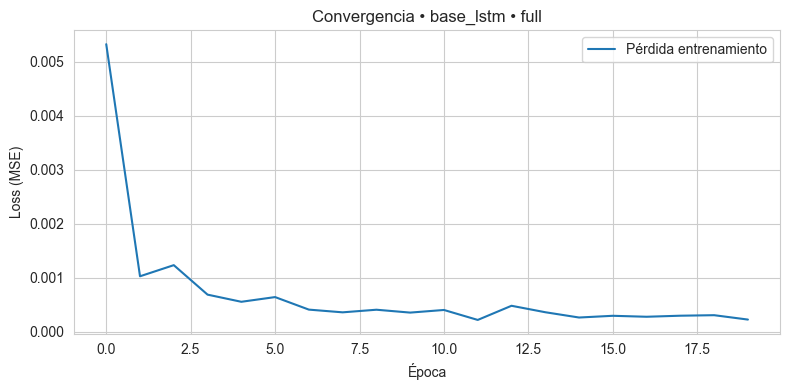

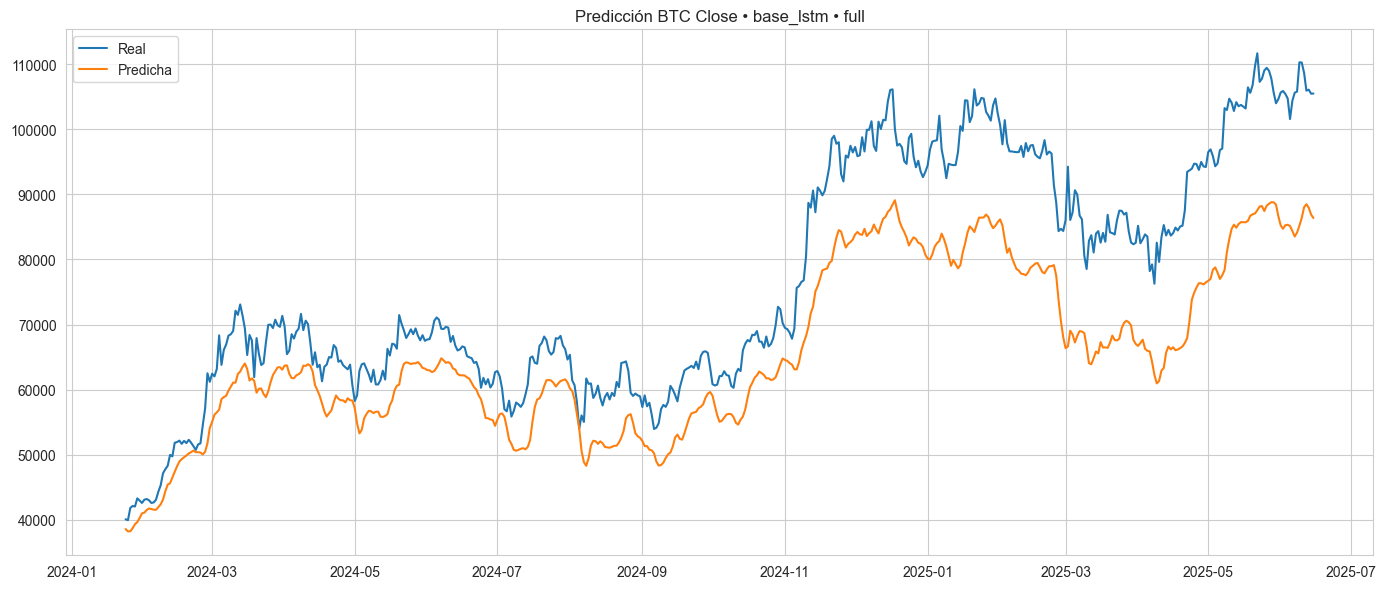

🟢 Entrenando base_lstm con features full_no_eth_fear_greed


/Users/cbarril/dev/posgrado/tp_ast1_19co2024/ast1/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


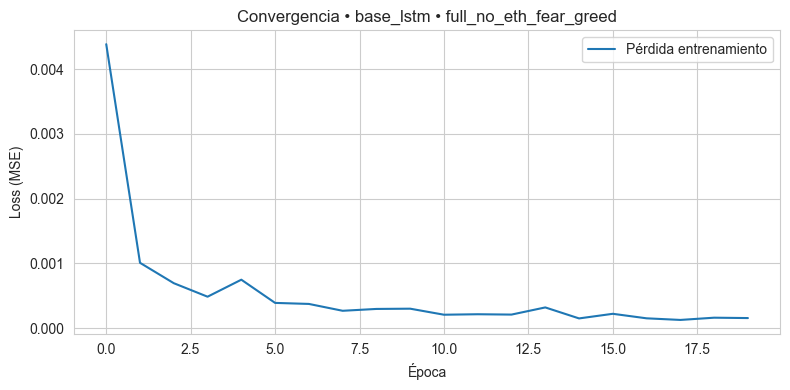

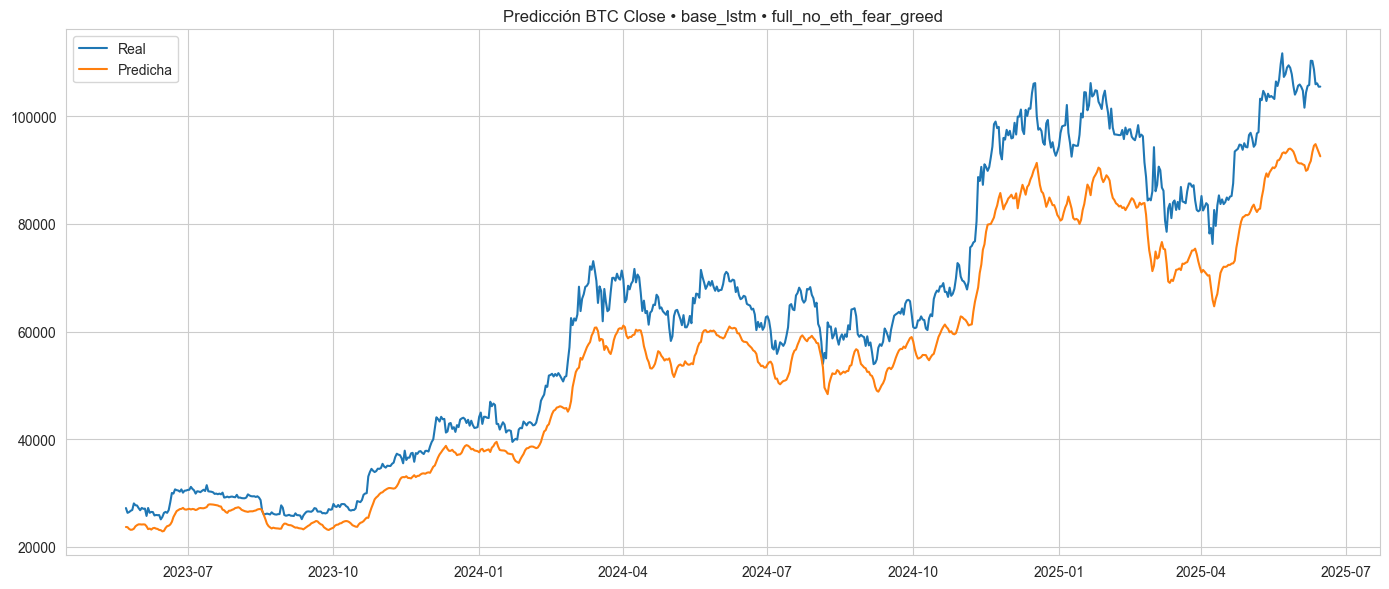

🟢 Entrenando base_lstm con features macro


/Users/cbarril/dev/posgrado/tp_ast1_19co2024/ast1/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


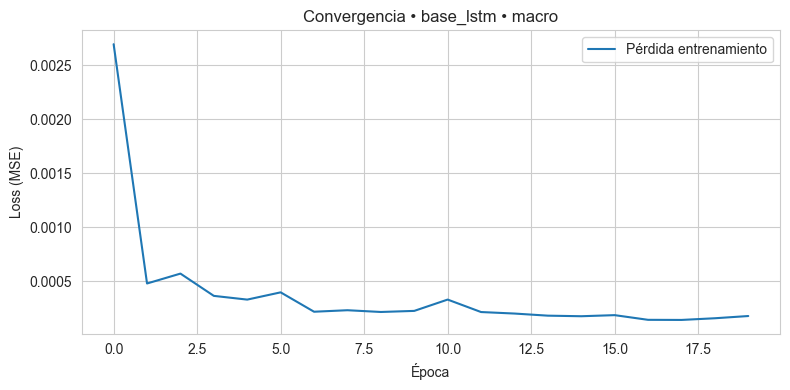

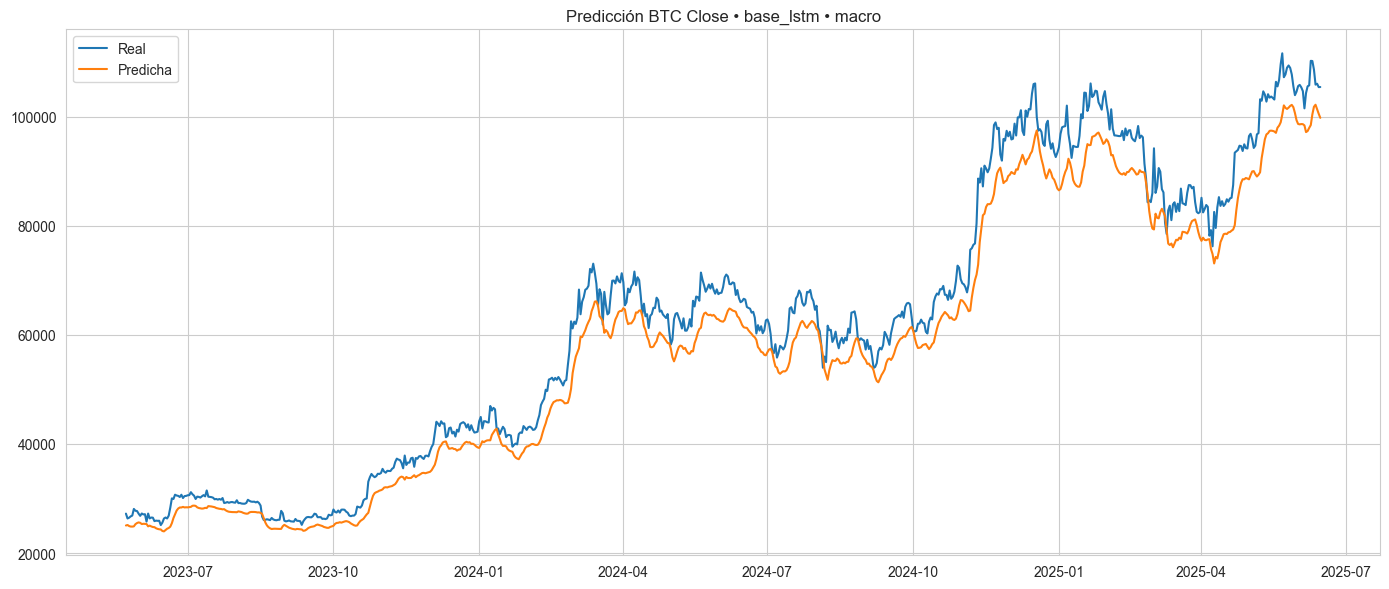

🟢 Entrenando base_lstm con features on-chain


/Users/cbarril/dev/posgrado/tp_ast1_19co2024/ast1/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


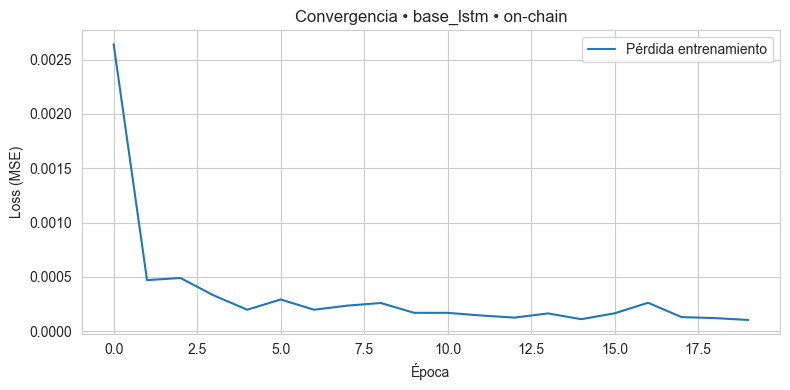

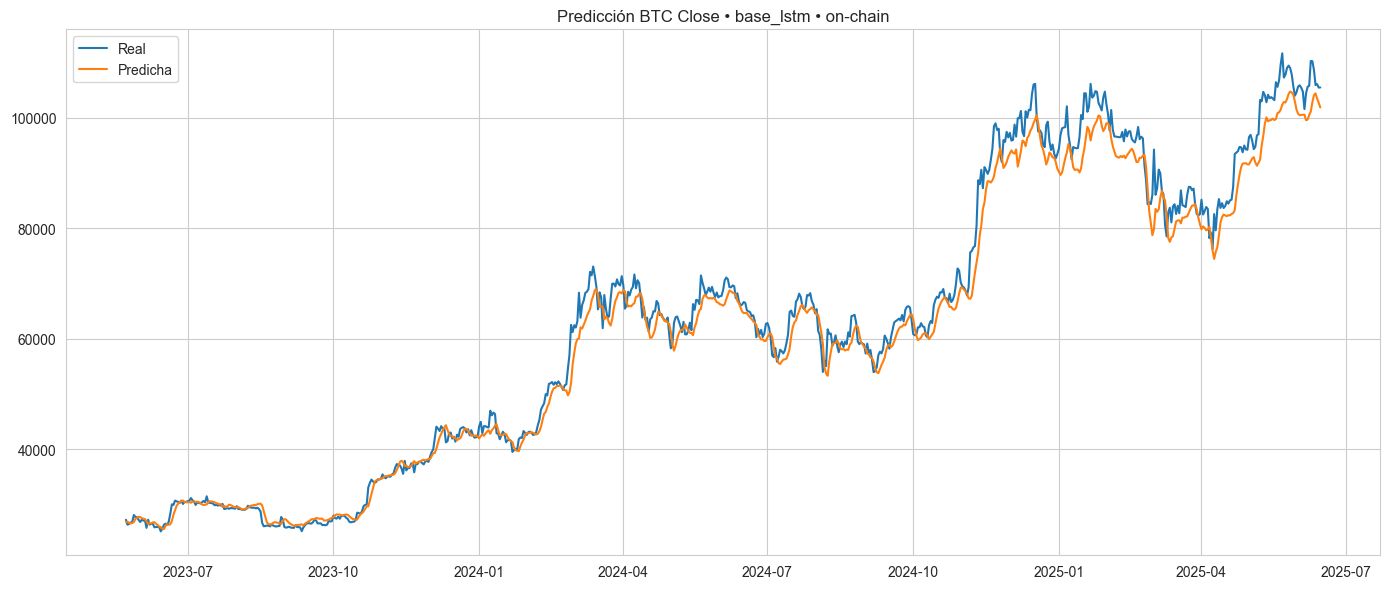

🟢 Entrenando base_lstm con features crypto


/Users/cbarril/dev/posgrado/tp_ast1_19co2024/ast1/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


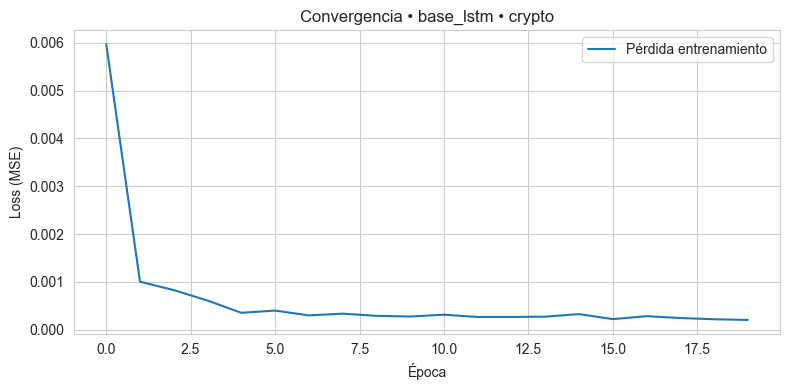

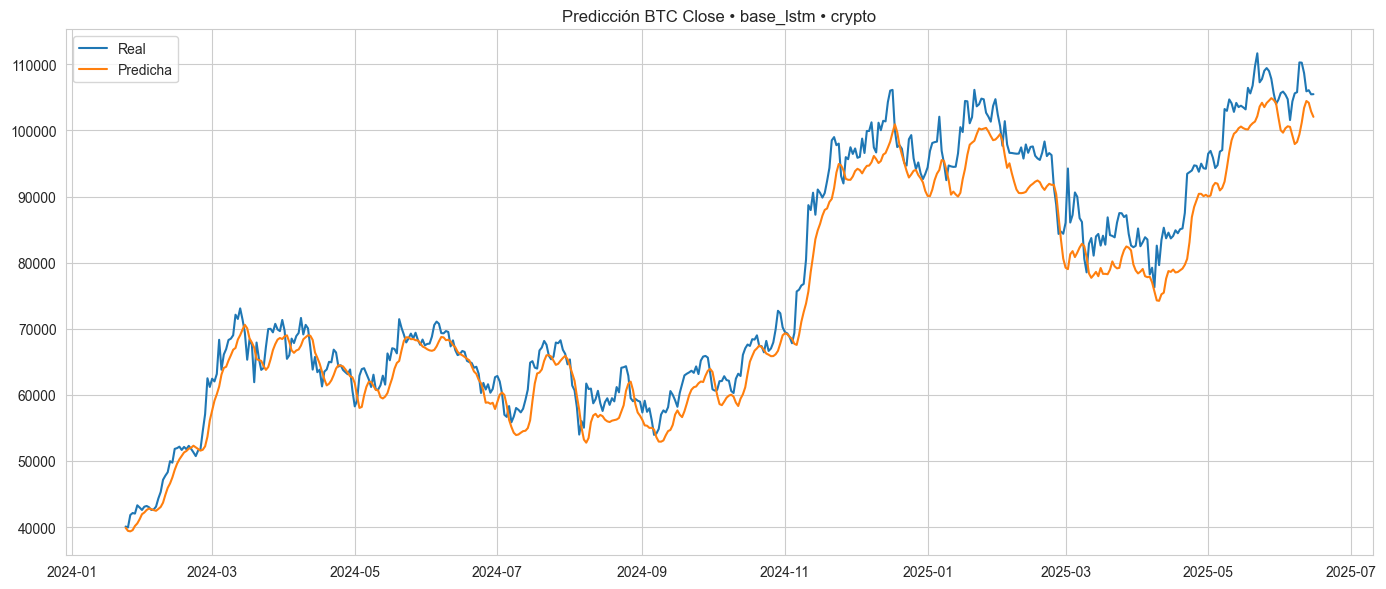

In [185]:
results = []
output_dir = '../models'
os.makedirs(output_dir, exist_ok=True)

for feat_name, feat_cols in FEATURE_SETS.items():
    idx, scaler, train, test, gens, split_idx = load_and_scale(
        '../datasets/merged/master_improved.csv', feat_cols
    )
    input_shape = (gens['train'].length, train.shape[1])

    model = base_lstm(input_shape)
    model_name = "base_lstm"

    print(f'🟢 Entrenando {model_name} con features {feat_name}')
    history = model.fit(gens['train'], epochs=20, verbose=0)

    # guarda en formato nativo keras → evita warning
    model.save(os.path.join(output_dir, f'{model_name}_{feat_name}.keras'))

    # guarda historial
    with open(os.path.join(output_dir, f'history_{model_name}_{feat_name}.pkl'), 'wb') as fh:
        pickle.dump(history.history, fh)

    # gráfico convergencia
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Pérdida entrenamiento')
    plt.xlabel('Época'); plt.ylabel('Loss (MSE)')
    plt.title(f'Convergencia • {model_name} • {feat_name}')
    plt.legend(); plt.tight_layout(); plt.show()

    # evaluación + gráfico predicción
    metrics, y_true, y_pred, test_dates = evaluate(
        model, gens['test'], test, scaler, split_idx, idx, 30, return_preds=True
    )
    metrics.update({'modelo': model_name, 'features': feat_name})
    results.append(metrics)

    graph_prediction(test_dates, y_true, y_pred, model_name, feat_name)

In [188]:
# Convertir a DataFrame y ordenar
chart = pd.DataFrame(results)
chart = chart.rename(columns={"mae": "mae_price", "rmse": "rmse_price"})
chart = chart[["features", "aic", "bic", "mae_price", "rmse_price"]]
ordered_chart = chart.sort_values(by="rmse_price")

# Mostrar en Markdown
print("\n📊 Comparación de modelos (formato Markdown):\n")
print(tabulate(ordered_chart, headers="keys", tablefmt="github", showindex=False))


📊 Comparación de modelos (formato Markdown):

| features               |     aic |     bic |   mae_price |   rmse_price |
|------------------------|---------|---------|-------------|--------------|
| on-chain               | 36037.6 | 86242.1 |     2270.76 |      3212.5  |
| crypto                 | 31643.6 | 77569.9 |     3391.78 |      4217.14 |
| macro                  | 37604.6 | 89659.8 |     4627.88 |      5338.94 |
| full_no_eth_fear_greed | 39239.7 | 93145.6 |     8137.75 |      9282.01 |
| full                   | 35138.6 | 86143.9 |    10682    |     12363.9  |
